# CS-E4600 — Programming project

## Imports

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.cluster.vq import vq, kmeans, whiten

## Read file

In [197]:
file = 'test.txt'
#file = 'ca-GrQc.txt'
#file = 'Oregon-1.txt'
#file = 'ca-HepPh.txt'

## Read First line info and Edges

In [198]:
with open('./graphs_processed/' + file) as f:
    first_line = f.readline()
first_line = first_line.split()

num_nodes = int(first_line[2])
num_edges = int(first_line[3])
k = int(first_line[4])
print(num_nodes, num_edges, k)

    
pd_edges = pd.read_csv('./graphs_processed/' + file, sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

8 11 2


## Select Distinct Nodes

In [199]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [200]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes and Edges to Numpy

In [201]:
nodes = pd_nodes.values
edges = pd_edges.values
nodes2 = np.arange(num_nodes)
#print(nodes.shape, nodes.shape)
print(nodes)
print(nodes2)
nodes = nodes2
#nodes.shape, edges.shape

[0 1 2 3 5 6 4 7]
[0 1 2 3 4 5 6 7]


## Create Adjacency Matrix

what to do with too big arrays??

In [202]:
adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

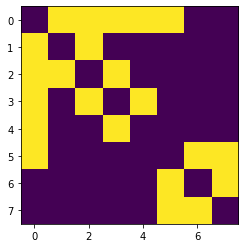

In [203]:
for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
plt.imshow(adjacency_matrix)

## Create Laplacian Matrix

In [204]:
laplacian = csgraph.laplacian(adjacency_matrix, normed=True)
np.sum(laplacian)

0.2532426070721109

## Alternative way for the Laplacian Matrix

In [205]:
degrees = np.sum(adjacency_matrix, axis=0)
L_normed = np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L_normed[i,j] = -1.0/(np.sqrt(degrees[i]*degrees[j]))

In [206]:
degrees = np.sum(adjacency_matrix, axis=0)
L = degrees * np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L[i,j] = -1

In [207]:
np.sum(L_normed)

0.2532426070721102

## Eigen-decomposition

In [208]:
_w, _v = np.linalg.eig(L_normed)

In [209]:
w, v = eigsh(laplacian, 5, which="SA")

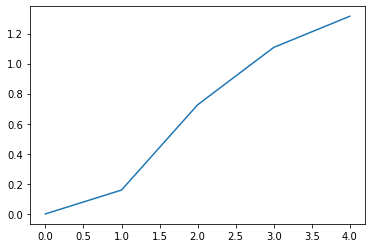

In [210]:
plt.plot(w)
plt.show()

## Selects second smallest eigenvalue and corresponding eigenvector

In [211]:
eig_val_idx = np.argpartition(w,2)[1]
eig_val_idx
eig_vec = v[:,eig_val_idx]

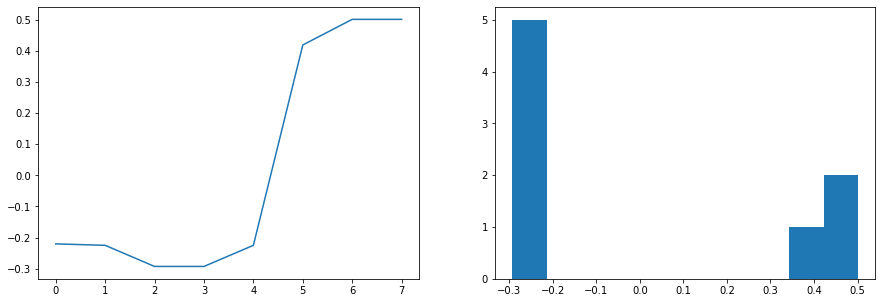

In [212]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(eig_vec)
plt.subplot(1, 2, 2)
plt.hist(eig_vec)
plt.show()

## K-means clustering

Should be improved to enforce balanced cluster sizes

In [213]:
whitened = whiten(eig_vec)
k_means = kmeans(eig_vec,k)
print(k_means)

(array([ 0.47398293, -0.25127395]), 0.03456712657056704)


## Select cluster for all vertices

## Calculate cost for clusters